In [6]:
import os
print(os.getcwd())
import matplotlib.pyplot as plt
import cv2
from realsense_sensor import RealsenseSensor
import imutils
import numpy as np
import cv_utils
import urx
import matplotlib.pyplot as plt

/home/dominik/git/TA


In [2]:
cam = RealsenseSensor("realsense_config.json")

2020-05-28 11:01:40.219 | INFO     | realsense_sensor:__init__:53 - Cam <pyrealsense2.device: Intel RealSense D415 (S/N: 821312061822)> connected.


In [3]:
cam.start()

2020-05-28 11:01:40.586 | INFO     | realsense_sensor:start:97 - Realsense stream started.


In [5]:
img, d = cam.frames()

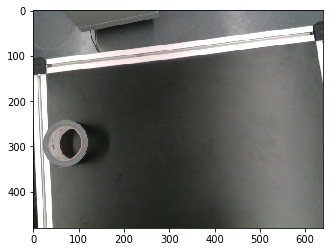

In [10]:
plt.imshow(img)

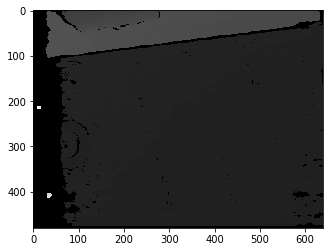

In [9]:
plt.imshow(d, cmap="gray")

In [7]:
intrinsics = cam.getIntrinsics()

In [9]:
intrinsics["px"]

320.8276672363281

In [2]:
#init robot
rob = urx.Robot("192.168.0.105")

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [3]:
print(rob.getl())

[-0.050666963214412025, -0.24468485744790108, 0.5268708297747503, 2.9433059081183215, -0.14374784279690994, 0.11738631024448798]


In [13]:
def gripper_close():
    rob.set_digital_out(0,True)
    rob.set_digital_out(1,False)
    
def gripper_open():
    rob.set_digital_out(0,False)
    rob.set_digital_out(1,True)

In [15]:
gripper_close()